In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import metrics

# Problem

See: https://docs.google.com/document/d/1JrWQk3fBPuydBjh6vJ-eQ0PoFlHixUxobpK_LJoZu_A/edit

The head of the Product team walks over to your desk and asks you what you think about the latest activity on the user engagement dashboards.

SQL code:
``` mysql
SELECT DATE_TRUNC('week', e.occurred_at),
       COUNT(DISTINCT e.user_id) AS weekly_active_users
  FROM tutorial.yammer_events e
 WHERE e.event_type = 'engagement'
   AND e.event_name = 'login'
 GROUP BY 1
 ORDER BY 1 
 ```


# Quick Summary

- More new users and new active users.
- Login rate drops could due to people go on vacation; it is user type dependent.

# Data

There are two time series data:
Events and emails.

In [2]:
!ls Data/*.csv

Data/dimension_rollup_periods.csv Data/yammer_events.csv
Data/employee_retention_data.csv  Data/yammer_users.csv
Data/yammer_emails.csv


In [3]:
df_user = pd.read_csv("Data/yammer_users.csv")
#print(df_user.info())

df_event = pd.read_csv("Data/yammer_events.csv")
#print(df_event.info())

df_email = pd.read_csv("Data/yammer_emails.csv")
#print(df_email.info())

df_period = pd.read_csv("Data/dimension_rollup_periods.csv")
#print(df_period.info())

In [4]:
## limit the period to the current time
df_period = df_period.loc[df_period.time_id < '2014-09-01']

In [5]:
#df_user.tail()

In [6]:
#df_period.tail()

First event is at 2014-05-02

In [7]:
#df_event.head()

In [8]:
# print(df_event.event_type.unique())
# print(df_event.event_name.unique())
# print(df_email.action.unique())
# print(df_event.device.unique())
# print(df_event.user_type.unique())

In [9]:
## convert occured_at to datetime
df_event.occurred_at = pd.to_datetime(df_event.occurred_at)
df_event["nweek"] = df_event.occurred_at.dt.week #strftime('%Y-%U')

In [10]:
## convert occured_at to datetime
df_email.occurred_at = pd.to_datetime(df_email.occurred_at)
df_email["nweek"] = df_email.occurred_at.dt.week #strftime('%Y-%U')

In [11]:
#df_email.tail()

# EDA

- From events we can reproduce the plot from SQL.
- From emails we can generate similar plots from actions.

It is interesting that the email opened by unique ID is increasing -- which means more user activity;
but emails that have blinks being clicked has the same trend as the login trend.

This suggests that the users are likely to be on vacation -- reading it but not logging in.

In [12]:
## event type can also be signup_flow
df_event_login = df_event.loc[(df_event.event_type == "engagement") & (df_event.event_name == "login")]
df_event_send = df_event.loc[(df_event.event_type == "engagement") & (df_event.event_name == "send_message")]

## event type can also be signup_flow
df_email_click = df_email.loc[(df_email.action == "email_clickthrough")]
df_email_open = df_email.loc[(df_email.action == "email_open")]
df_email_digest = df_email.loc[(df_email.action == "sent_weekly_digest")]


In [13]:
## create my data frame; sorted by each week and activities
my_df = pd.DataFrame()
my_df["login"] = df_event_login.groupby('nweek')['user_id'].nunique()
my_df["send_message"] = df_event_send.groupby('nweek')['user_id'].nunique()
my_df["email_open"] = df_email_open.groupby('nweek')['user_id'].nunique()
my_df["email_clickthrough"] = df_email_click.groupby('nweek')['user_id'].nunique()
#my_df["email_digest"] = df_email_digest.groupby('nweek')['user_id'].nunique()
#my_df.head()

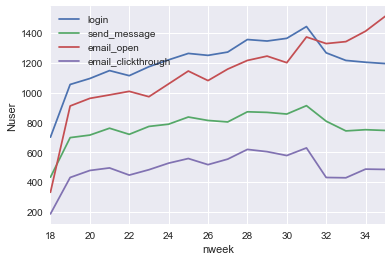

In [14]:
## reproduce plot in python
my_df.plot()
plt.ylabel("Nuser")
plt.legend()
plt.show()

It is very interesting that the email open rate rises and email click through rate drops, in particular.

# Model

### To support the vacation hypothesis, we need to have two informations: 
 - Number of registered user is increasing
 - User last activity and location 
 
The first information can come from the user table

In [15]:
#df_user.head()

In [16]:
#df_user.info()

In [17]:
df_user.created_at = pd.to_datetime(df_user.created_at)
df_user.activated_at = pd.to_datetime(df_user.activated_at)

## keep users created after 2014-05-02
#df_user = df_user.loc[df_user.created_at > '2014-05-01']

## convert date into weeks
df_user["nweek_create"] = df_user.created_at.dt.week
df_user["nweek_active"]   = df_user.activated_at.dt.week

In [18]:
## Add them to my df
my_df["user_create"] = df_user.groupby('nweek_create')['user_id'].nunique()
my_df["user_active"] = df_user.groupby('nweek_active')['user_id'].nunique()

In [19]:
## Add company to my df
my_df["company_create"] = df_user.groupby('nweek_create')['company_id'].nunique()
my_df["company_active"]   = df_user.groupby('nweek_active')['company_id'].nunique()

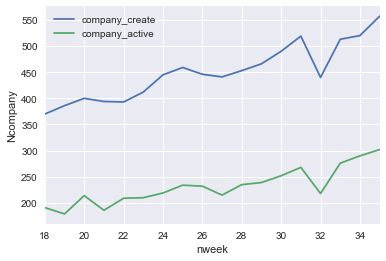

In [20]:
my_df["company_create"].plot()
my_df["company_active"].plot()
plt.ylabel("Ncompany")
plt.legend()
plt.show()

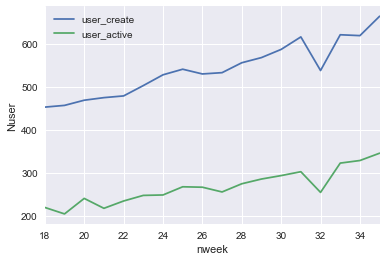

In [21]:
my_df["user_create"].plot()
my_df["user_active"].plot()
plt.ylabel("Nuser")
plt.legend()
plt.show()

The above plots shows the creation and activation of new user is both increasing

### For on vacation hypothesis, we need to merge DFs

In [22]:
merge_event = df_event.merge(df_user, on="user_id", how = 'inner')
merge_event = merge_event.loc[(merge_event.event_name == "login")]

In [23]:
merge_email = df_email.merge(df_user, on="user_id", how = 'inner')

In [24]:
#merge_event.tail()

In [25]:
#merge_email.tail()

In [26]:
merge_event.groupby('location')['user_id'].nunique().argmax()

'United States'

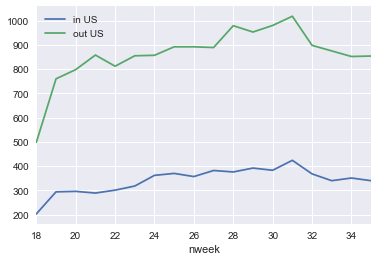

In [27]:
merge_event.loc[(merge_event.location == 'United States')].groupby('nweek')['user_id'].nunique().plot(label="in US")
merge_event.loc[(merge_event.location != 'United States')].groupby('nweek')['user_id'].nunique().plot(label="out US")
plt.legend()
plt.show()

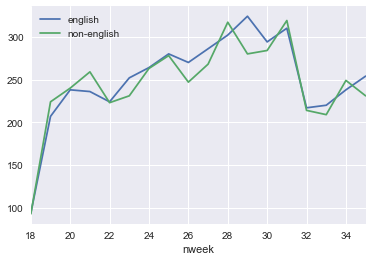

In [28]:
merge_email.loc[(merge_email.language == 'english') & (merge_email.action == "email_clickthrough")].groupby('nweek')['user_id'].nunique().plot(label="english")
merge_email.loc[(merge_email.language != 'english') & (merge_email.action == "email_clickthrough")].groupby('nweek')['user_id'].nunique().plot(label="non-english")
plt.legend()
plt.show()


language makes no difference

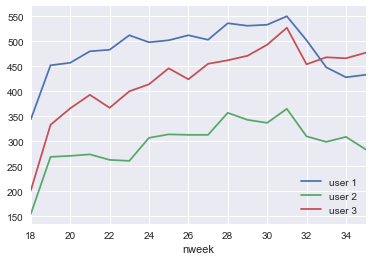

In [29]:
merge_event.loc[(merge_event.user_type == 1)].groupby('nweek')['user_id'].nunique().plot(label="user 1")
merge_event.loc[(merge_event.user_type == 2)].groupby('nweek')['user_id'].nunique().plot(label="user 2")
merge_event.loc[(merge_event.user_type == 3)].groupby('nweek')['user_id'].nunique().plot(label="user 3")
plt.legend()
plt.show()

user type seems to make a difference; type 1 and 2 are more inactive than type 3

In [30]:
merge_event["hasphone"] = merge_event.device.str.contains('phone')

In [31]:
my_df["user_1phone"]= merge_event.loc[(merge_event.user_type == 1) & 
                                      (merge_event.hasphone == True)].groupby('nweek')['user_id'].nunique()
my_df["user_1nophone"]= merge_event.loc[(merge_event.user_type == 1) & 
                                      (merge_event.hasphone == False)].groupby('nweek')['user_id'].nunique()
my_df["user_2phone"]= merge_event.loc[(merge_event.user_type == 2) & 
                                      (merge_event.hasphone == True)].groupby('nweek')['user_id'].nunique()
my_df["user_2nophone"]= merge_event.loc[(merge_event.user_type == 2) & 
                                      (merge_event.hasphone == False)].groupby('nweek')['user_id'].nunique()
my_df["user_3phone"]= merge_event.loc[(merge_event.user_type == 3) & 
                                      (merge_event.hasphone == True)].groupby('nweek')['user_id'].nunique()
my_df["user_3nophone"]= merge_event.loc[(merge_event.user_type == 3) & 
                                      (merge_event.hasphone == False)].groupby('nweek')['user_id'].nunique()

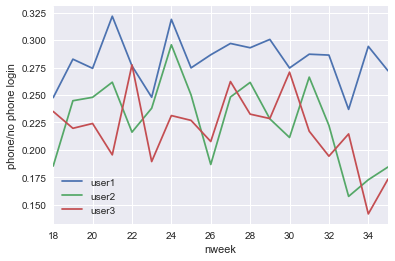

In [32]:
(my_df["user_1phone"]/my_df["user_1nophone"]).plot(label="user1")
(my_df["user_2phone"]/my_df["user_2nophone"]).plot(label="user2")
(my_df["user_3phone"]/my_df["user_3nophone"]).plot(label="user3")
plt.ylabel("phone/no phone login")
plt.legend()
plt.show()

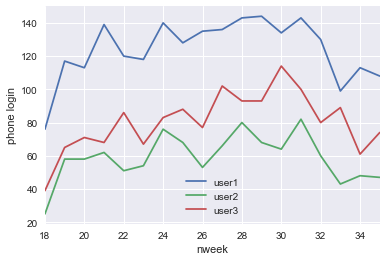

In [33]:
(my_df["user_1phone"]).plot(label="user1")
(my_df["user_2phone"]).plot(label="user2")
(my_df["user_3phone"]).plot(label="user3")
plt.ylabel("phone login")
plt.legend()
plt.show()

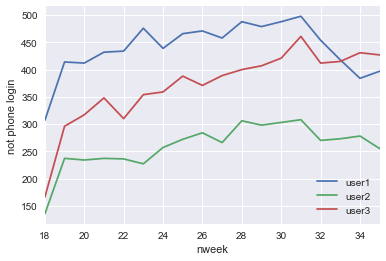

In [34]:
(my_df["user_1nophone"]).plot(label="user1")
(my_df["user_2nophone"]).plot(label="user2")
(my_df["user_3nophone"]).plot(label="user3")
plt.ylabel("not phone login")
plt.legend()
plt.show()

In [35]:
# temp = my_df.pct_change()
# (temp["user_1phone"]/temp["user_1nophone"]).plot(label="user1")
# (temp["user_2phone"]/temp["user_2nophone"]).plot(label="user2")
# (temp["user_3phone"]/temp["user_3nophone"]).plot(label="user3")
# plt.ylabel("phone/no phone login")
# plt.legend()
# plt.show()

This plot is very juicy. 

People using phones tends to drop at higher rate than people not using phones in the same period. 

This supports the vacation hypothesis.

# Summary

Overall, there is no significant drop of using. The new users are increasing. The email opening are also increasing. 

The login rate drop could come from people going on vacation. It is also user type dependent.

# Future

The phone user hypothesis could be tested better.